In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import numpy as np
from scipy.stats import spearmanr

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

In [4]:
#csv file of all electrophysiology, morphology features, ion conductance, nm_id
all_features = pd.read_csv("C:/Users/Allose/Notebook/all_features.csv", index_col=0)
#csv file of all electrophysiology, morphology features, ion conductance, nm_id, including cell type
all_features_cell_type = pd.read_csv("C:/Users/Allose/Notebook/all_features_cell_type.csv", index_col=0)

#transcriptomic gene expression data by cell type
transcriptome_df = pd.read_csv("C:/Users/Allose/Notebook/transcriptome_df.csv", index_col=0)
#transcriptomic gene expressions data with all separate cortical layers
new_transcriptome_df = pd.read_csv('C:/Users/Allose/Notebook/sep_layer_df.csv', index_col=0)
#transcriptomic gene expression data with only cre-line
new_label_df = pd.read_csv("C:/Users/Allose/Notebook/new_label_transcriptome_df.csv", index_col=0)

#relavtive ion conductance data for only cre-lines
cre_parameter_df = pd.read_csv("C:/Users/Allose/Notebook/cre_parameter_df.csv", index_col=0)
#absolute ion conductance data for cell types
abs_parameter_df = pd.read_csv("C:/Users/Allose/Notebook/abs_parameter_df.csv", index_col=0)
#relative conductance data for cell types
sep_layer_cre_parameter_df = pd.read_csv('sep_layer_cre_parameter_df.csv', index_col=0)

#csv for entrenz symbol and associated gene
entrenz_symbol_s = pd.Series.from_csv("C:/Users/Allose/Notebook/entrenz_symbol_s.csv", index_col=0)

#csv file about channel genes and their associated ion channels
ion_channel_genes = pd.read_csv("C:/Users/Allose/Notebook/targets_and_families.csv", index_col=0)

#Spearman Correlation ranks at cre-line level
f = open("new_spearman_corr_ranks.json","r")
data = json.load(f)
spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and relative conductance
f = open("sep_spearman_corr_ranks.json","r")
data = json.load(f)
sep_spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and absolute conductance
f = open("abs_spearman_corr_ranks.json","r")
data = json.load(f)
abs_spearman_corr_ranks = data
f.close()



sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#Parameter names
parameters = ['gbar_Im',
              'gbar_Ih',
              'gbar_NaTs',
              'gbar_Nap',
              'gbar_K_P',
              'gbar_K_T',
              'gbar_SK',
              'gbar_Kv3_1',
              'gbar_Ca_HVA',
              'gbar_Ca_LVA',
              'gamma_CaDynamics',
              'decay_CaDynamics',
              'soma_g_pas',
              'axon_g_pas',
              'dend_g_pas',
              'apic_g_pas',
              'gbar_NaV',
              'gbar_Kd',
              'gbar_Kv2like',
              'gbar_Im_v2']

#Parameter names for absolute conductance
abs_parameters = ['abs_gbar_Im',
 'abs_gbar_Ih',
 'abs_gbar_NaTs',
 'abs_gbar_Nap',
 'abs_gbar_K_P',
 'abs_gbar_K_T',
 'abs_gbar_SK',
 'abs_gbar_Kv3_1',
 'abs_gbar_Ca_HVA',
 'abs_gbar_Ca_LVA',
 'abs_gamma_CaDynamics',
 'abs_decay_CaDynamics',
 'abs_soma_g_pas',
 'abs_axon_g_pas',
 'abs_dend_g_pas',
 'abs_apic_g_pas',
 'abs_gbar_NaV',
 'abs_gbar_Kd',
 'abs_gbar_Kv2like',
 'abs_gbar_Im_v2']

#6 Parameters shared by all neuronal models
shared_parameters = ['gbar_Ih', 'gbar_K_T', 'gbar_SK', 'gbar_Kv3_1', 'gbar_Ca_HVA', 'gbar_Ca_LVA']

#List of gene channels that are voltage gated
ion_channel_genes = ion_channel_genes[ion_channel_genes['MGI symbol'].notnull()]
gene_channel = ion_channel_genes.loc["vgic"]
gene_channel = gene_channel['MGI symbol'].values
gene_channel = list(gene_channel)

C:\Users\Allose\Anaconda3\lib\site-packages\pandas\core\series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [5]:
all_features['cell_type'] = 'False'
cre_layer_dendrite = all_features[['cre_line', 'structure_layer', 'dendrite_type', 'nm_id', 'reconstruction_type']]

for index, row in cre_layer_dendrite.iterrows():
    if row['structure_layer'][0] != '6':
        layer_label = 'L' + row['structure_layer']
    else:
        layer_label = 'L6'
    if row['dendrite_type'] == 'spiny':
        dendrite_label = 'exc'
    else:
        dendrite_label = 'inh'
    all_features.set_value(index, 'cell_type', '{}__{}__{}'.format(row['cre_line'], layer_label, dendrite_label))

C:\Users\Allose\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


In [6]:
e_feature = 'upstroke_downstroke_ratio_long_square'

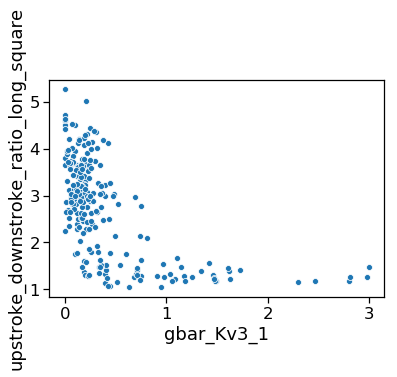

In [7]:
individual = all_features[['cell_type', 'upstroke_downstroke_ratio_long_square', 'gbar_Kv3_1']]
individual = individual[individual['gbar_Kv3_1'].notna()]
ax = sns.scatterplot(x='gbar_Kv3_1', y='upstroke_downstroke_ratio_long_square', data=individual)


In [19]:
feature_type = all_features[['cell_type', e_feature]]
avg_feature_type = feature_type.groupby('cell_type')[e_feature].mean()
filtered_avg_feature_type = avg_feature_type.filter(items=cre_color_inc_4)
filtered_avg_feature_type

cell_type
Htr3a-Cre_NO152__L2/3__inh    3.064885
Htr3a-Cre_NO152__L5__inh      2.553926
Nr5a1-Cre__L4__exc            3.317217
Ntsr1-Cre_GN220__L6__exc      2.675545
Pvalb-IRES-Cre__L2/3__inh     1.228157
Pvalb-IRES-Cre__L4__inh       1.269192
Pvalb-IRES-Cre__L5__inh       1.291943
Pvalb-IRES-Cre__L6__inh       1.272215
Rbp4-Cre_KL100__L4__exc       3.519512
Rbp4-Cre_KL100__L5__exc       3.247559
Scnn1a-Tg2-Cre__L4__exc       3.495614
Sst-IRES-Cre__L5__inh         1.809795
Sst-IRES-Cre__L6__inh         1.683218
Name: upstroke_downstroke_ratio_long_square, dtype: float64

[0.235401949264024, 0.6386037876519687, 0.12618227941410484, 0.14960081771511394, 0.6933117129540817, 1.1212459226154838, 1.2667717946758559, 1.2507790005131003, 0.1906759220690016, 0.12429393256523773, 0.11857144286778047, 0.5152661461738804, 0.6618929837181058]
                            gbar_Kv3_1  upstroke_downstroke_ratio_long_square
cell_type                                                                    
Htr3a-Cre_NO152__L2/3__inh    0.235402                               3.064885
Htr3a-Cre_NO152__L5__inh      0.638604                               2.553926
Nr5a1-Cre__L4__exc            0.126182                               3.317217
Ntsr1-Cre_GN220__L6__exc      0.149601                               2.675545
Pvalb-IRES-Cre__L2/3__inh     0.693312                               1.228157
Pvalb-IRES-Cre__L4__inh       1.121246                               1.269192
Pvalb-IRES-Cre__L5__inh       1.266772                               1.291943
Pvalb-IRES-Cre__L6__inh       1.25

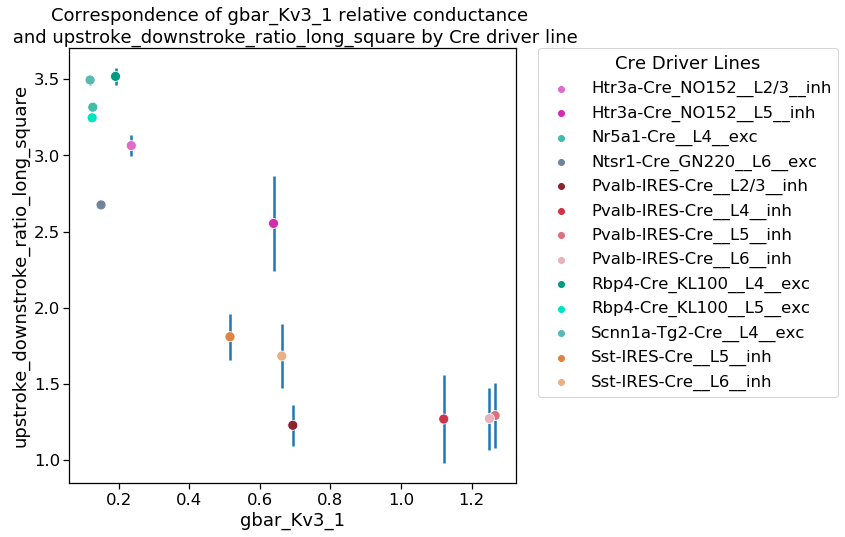

In [36]:
cre_color_inc_4 = ['Htr3a-Cre_NO152__L2/3__inh',
             'Htr3a-Cre_NO152__L5__inh',
             'Nr5a1-Cre__L4__exc',
             'Ntsr1-Cre_GN220__L6__exc',
             'Pvalb-IRES-Cre__L2/3__inh',
             'Pvalb-IRES-Cre__L4__inh',
             'Pvalb-IRES-Cre__L5__inh',
             'Pvalb-IRES-Cre__L6__inh',
             'Rbp4-Cre_KL100__L4__exc',
             'Rbp4-Cre_KL100__L5__exc',
             'Scnn1a-Tg2-Cre__L4__exc',
             'Sst-IRES-Cre__L5__inh',
             'Sst-IRES-Cre__L6__inh']

parameter_type = 'gbar_Kv3_1'
cre_parameter_df_spec = sep_layer_cre_parameter_df[[parameter_type]]
cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_4 , : ]
filtered_cre = list(cre_conductance_filtered.index)
    
graph_spec = pd.concat([cre_conductance_filtered, filtered_avg_feature_type], axis = 1)
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x=parameter_type, y=e_feature, hue=cre_color_inc_4, data=graph_spec, s = 100, palette=cre_line_palette_inc_4)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Driver Lines")

x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
print(x_coords)
print(graph_spec)
    
std_cre = sem.loc[cre_color_inc_4,:]
errors = std_cre[parameter_type]
ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', zorder=-1)
plt.title('Correspondence of {} relative conductance \n and {} by Cre driver line'.format(parameter_type, e_feature))
plt.savefig("{}_{}.svg".format(parameter_type, e_feature), format="svg")


In [34]:
#Set-up for palette for cell types based on Cre-line
cre_color = ['Gad2-IRES-Cre__L5__inh',
             'Htr3a-Cre_NO152__L2/3__inh',
             'Htr3a-Cre_NO152__L4__inh',
             'Htr3a-Cre_NO152__L5__inh',
             'Htr3a-Cre_NO152__L5-L6__exc',
             'Nr5a1-Cre__L4__exc',
             'Ntsr1-Cre_GN220__L6__exc',
             'Pvalb-IRES-Cre__L2/3__inh',
             'Pvalb-IRES-Cre__L4__inh',
             'Pvalb-IRES-Cre__L5__inh',
             'Pvalb-IRES-Cre__L6__inh',
             'Rbp4-Cre_KL100__L4__exc',
             'Rbp4-Cre_KL100__L5__exc',
             'Scnn1a-Tg2-Cre__L4__exc',
             'Scnn1a-Tg3-Cre__L2/3-L4__exc',
             'Sst-IRES-Cre__L1-L2/3__inh',
             'Sst-IRES-Cre__L4__inh',
             'Sst-IRES-Cre__L5__inh',
             'Sst-IRES-Cre__L6__inh']

cre_line_palette = {'Gad2-IRES-Cre__L5__inh':"#D98463", 
                    'Htr3a-Cre_NO152__L2/3__inh':"#DF6BC6", 
                    'Htr3a-Cre_NO152__L4__inh':"#DF6BC6", 
                    'Htr3a-Cre_NO152__L5__inh':"#DF6BC6", 
                    'Htr3a-Cre_NO152__L5-L6__exc':"#DF6BC6", 
                    'Nr5a1-Cre__L4__exc':"#43BCA9",
                    'Ntsr1-Cre_GN220__L6__exc':"#70849A",
                    'Pvalb-IRES-Cre__L2/3__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L4__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L5__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L6__inh':"#CD3449",
                    'Rbp4-Cre_KL100__L4__exc':"#009B81",
                    'Rbp4-Cre_KL100__L5__exc':"#009B81",
                    'Scnn1a-Tg2-Cre__L4__exc':"#59B7B4",
                    'Scnn1a-Tg3-Cre__L2/3-L4__exc':"#65AA8A",
                    'Sst-IRES-Cre__L1-L2/3__inh':"#B35F1F",
                    'Sst-IRES-Cre__L4__inh':"#B35F1F",
                    'Sst-IRES-Cre__L5__inh':"#B35F1F",
                    'Sst-IRES-Cre__L6__inh':"#B35F1F"}

In [ ]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[filtered_cre])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    plt.figure(figsize=(8, 8))
    plt.title('Correspondence of {} relative conductance \n and {} gene expression by Cre driver line'.format(parameter_type, gene_symbol))
    
    
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=cre_color, data=graph_spec, s = 100, palette=cre_line_palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Driver Lines")

    ax.set(xlabel='{} Transcriptomic Gene Expression'.format(gene_symbol), ylabel='{} Conductance'.format(parameter_type))

In [ ]:
filtered_group = ["Htr3a-Cre_NO152__L2/3__inh", "Htr3a-Cre_NO152__L5__inh", "Nr5a1-Cre__L4__exc", "Ntsr1-Cre_GN220__L6__exc", 
 "Pvalb-IRES-Cre__L2/3__inh", "Pvalb-IRES-Cre__L4__inh", "Pvalb-IRES-Cre__L5__inh", "Pvalb-IRES-Cre__L6__inh", 
 "Rbp4-Cre_KL100__L4__exc", "Rbp4-Cre_KL100__L5__exc", "Scnn1a-Tg2-Cre__L4__exc", "Scnn1a-Tg3-Cre__L4__exc", 
 "Sst-IRES-Cre__L2/3__inh", "Sst-IRES-Cre__L5__inh", "Sst-IRES-Cre__L6__inh"]


In [ ]:
#Set-up for palette for cell types based on Cre-line
cre_color_inc_4 = ['Htr3a-Cre_NO152__L2/3__inh',
             'Htr3a-Cre_NO152__L5__inh',
             'Nr5a1-Cre__L4__exc',
             'Ntsr1-Cre_GN220__L6__exc',
             'Pvalb-IRES-Cre__L2/3__inh',
             'Pvalb-IRES-Cre__L4__inh',
             'Pvalb-IRES-Cre__L5__inh',
             'Pvalb-IRES-Cre__L6__inh',
             'Rbp4-Cre_KL100__L4__exc',
             'Rbp4-Cre_KL100__L5__exc',
             'Scnn1a-Tg2-Cre__L4__exc',
             'Scnn1a-Tg3-Cre__L2/3-L4__exc',
             'Sst-IRES-Cre__L1-L2/3__inh',
             'Sst-IRES-Cre__L5__inh',
             'Sst-IRES-Cre__L6__inh']

cre_line_palette_inc_4 = {'Htr3a-Cre_NO152__L2/3__inh':"#DF6BC6",
                    'Htr3a-Cre_NO152__L5__inh':"#DF6BC6", 
                    'Nr5a1-Cre__L4__exc':"#43BCA9",
                    'Ntsr1-Cre_GN220__L6__exc':"#70849A",
                    'Pvalb-IRES-Cre__L2/3__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L4__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L5__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L6__inh':"#CD3449",
                    'Rbp4-Cre_KL100__L4__exc':"#009B81",
                    'Rbp4-Cre_KL100__L5__exc':"#009B81",
                    'Scnn1a-Tg2-Cre__L4__exc':"#59B7B4",
                    'Scnn1a-Tg3-Cre__L2/3-L4__exc':"#65AA8A",
                    'Sst-IRES-Cre__L1-L2/3__inh':"#B35F1F",
                    'Sst-IRES-Cre__L5__inh':"#B35F1F",
                    'Sst-IRES-Cre__L6__inh':"#B35F1F"}

In [35]:
#Set-up for palette for cell types based on Cre-line
cre_color_inc_4 = ['Htr3a-Cre_NO152__L2/3__inh',
             'Htr3a-Cre_NO152__L5__inh',
             'Nr5a1-Cre__L4__exc',
             'Ntsr1-Cre_GN220__L6__exc',
             'Pvalb-IRES-Cre__L2/3__inh',
             'Pvalb-IRES-Cre__L4__inh',
             'Pvalb-IRES-Cre__L5__inh',
             'Pvalb-IRES-Cre__L6__inh',
             'Rbp4-Cre_KL100__L4__exc',
             'Rbp4-Cre_KL100__L5__exc',
             'Scnn1a-Tg2-Cre__L4__exc',
             'Scnn1a-Tg3-Cre__L2/3-L4__exc',
             'Sst-IRES-Cre__L1-L2/3__inh',
             'Sst-IRES-Cre__L5__inh',
             'Sst-IRES-Cre__L6__inh']

cre_line_palette_inc_4 = {'Htr3a-Cre_NO152__L2/3__inh':"#DF6BC6",
                    'Htr3a-Cre_NO152__L5__inh':"#D12DAD", 
                    'Nr5a1-Cre__L4__exc':"#43BCA9",
                    'Ntsr1-Cre_GN220__L6__exc':"#70849A",
                    'Pvalb-IRES-Cre__L2/3__inh':"#8E2331",
                    'Pvalb-IRES-Cre__L4__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L5__inh':"#DB707E",
                    'Pvalb-IRES-Cre__L6__inh':"#EBB1b9",
                    'Rbp4-Cre_KL100__L4__exc':"#009B81",
                    'Rbp4-Cre_KL100__L5__exc':"#00E5BF",
                    'Scnn1a-Tg2-Cre__L4__exc':"#59B7B4",
                    'Scnn1a-Tg3-Cre__L2/3-L4__exc':"#65AA8A",
                    'Sst-IRES-Cre__L1-L2/3__inh':"#B35F1F",
                    'Sst-IRES-Cre__L5__inh':"#DD8440",
                    'Sst-IRES-Cre__L6__inh':"#E9B085"}

In [26]:
shortened_color = ['Htr3a L2/3', 
                   "Htr3a L5",  
             'Nr5a1 L4',
             'Ntsr1 L6',
             'Pvalb L2/3',
             'Pvalb L4',
             'Pvalb L5',
             'Pvalb L6',
             'Rbp4 L4',
             'Rbp4 L5',
             'Scnn1a-Tg2 L4',
             'Sst L5',
             'Sst L6']

shortened_palette = cre_line_palette_inc_4 = {'Htr3a L2/3':"#DF6BC6",
                    'Htr3a L5':"#D12DAD", 
                    'Nr5a1 L4':"#43BCA9",
                    'Ntsr1 L6':"#70849A",
                    'Pvalb L2/3':"#8E2331",
                    'Pvalb L4':"#CD3449",
                    'Pvalb L5':"#DB707E",
                    'Pvalb L6':"#EBB1b9",
                    'Rbp4 L4':"#009B81",
                    'Rbp4 L5':"#00E5BF",
                    'Scnn1a-Tg2 L4':"#59B7B4",
                    'Sst L5':"#DD8440",
                    'Sst L6':"#E9B085"}

In [15]:
index_name = ['cell_type',
                'gbar_Im',
              'gbar_Ih',
              'gbar_NaTs',
              'gbar_Nap',
              'gbar_K_P',
              'gbar_K_T',
              'gbar_SK',
              'gbar_Kv3_1',
              'gbar_Ca_HVA',
              'gbar_Ca_LVA',
              'gamma_CaDynamics',
              'decay_CaDynamics',
              'soma_g_pas',
              'axon_g_pas',
              'dend_g_pas',
              'apic_g_pas',
              'gbar_NaV',
              'gbar_Kd',
              'gbar_Kv2like',
              'gbar_Im_v2']
stdcal = all_features_cell_type[all_features_cell_type['gbar_Ih'].notna()]
stdcal = stdcal[stdcal['cell_type'] != 'False']
stdcal = stdcal[index_name]
std = stdcal.groupby('cell_type').std()
std.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                     "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                 inplace = True) 
std.loc[cre_color_inc_4,:]


,gbar_Im,gbar_Ih,gbar_NaTs,gbar_Nap,gbar_K_P,gbar_K_T,gbar_SK,gbar_Kv3_1,gbar_Ca_HVA,gbar_Ca_LVA,gamma_CaDynamics,decay_CaDynamics,soma_g_pas,axon_g_pas,dend_g_pas,apic_g_pas,gbar_NaV,gbar_Kd,gbar_Kv2like,gbar_Im_v2
cell_type,,,,,,,,,,,,,,,,,,,,
Htr3a-Cre_NO152__L2/3__inh,0.000951,0.001430,0.055130,0.000781,0.068434,0.042889,0.148702,0.201530,0.000370,0.002251,0.016714,317.139670,0.000289,0.000379,2.613009e-04,NaN,0.020214,3.475436e-05,0.043394,0.002736
Htr3a-Cre_NO152__L5__inh,NaN,0.000230,NaN,NaN,NaN,0.029613,0.000924,0.618926,0.000245,0.003251,0.021083,275.969935,0.000279,0.000247,3.675739e-05,NaN,0.041471,1.100992e-05,0.013766,0.007363
Nr5a1-Cre__L4__exc,0.002305,0.000396,0.184829,0.001255,0.054327,0.013678,0.040705,0.073313,0.000259,0.003301,0.008890,274.589148,0.000170,0.000256,7.797108e-05,0.000056,0.041488,1.784853e-03,0.027016,0.004021
Ntsr1-Cre_GN220__L6__exc,0.001066,0.000239,0.203777,0.000227,0.023763,0.013911,0.071369,0.063191,0.000331,0.003072,0.000877,320.946137,0.000332,0.000298,6.314987e-05,0.000043,NaN,NaN,NaN,NaN
Pvalb-IRES-Cre__L2/3__inh,NaN,0.000359,NaN,NaN,NaN,0.039904,0.027301,0.301540,0.000419,0.001433,0.020077,236.361499,0.000377,0.000393,2.695735e-05,NaN,0.020200,2.101923e-06,0.112416,0.005152
Pvalb-IRES-Cre__L4__inh,NaN,0.001569,NaN,NaN,NaN,0.013269,0.048495,0.711426,0.000319,0.003703,0.009048,227.585518,0.000210,0.000132,1.492417e-04,NaN,0.033591,4.364341e-04,0.039186,0.004279
Pvalb-IRES-Cre__L5__inh,NaN,0.000977,NaN,NaN,NaN,0.023769,0.086699,0.773044,0.000322,0.004113,0.016771,292.201815,0.000317,0.000342,1.962903e-04,NaN,0.013398,2.199969e-04,0.093337,0.003301
Pvalb-IRES-Cre__L6__inh,NaN,0.000360,NaN,NaN,NaN,0.021270,0.000104,0.408199,0.000355,0.001676,0.011866,326.222968,0.000352,0.000495,1.562213e-08,NaN,0.044466,1.644246e-03,0.014913,0.003150
Rbp4-Cre_KL100__L4__exc,0.011375,0.000368,0.598312,0.001828,0.023218,0.001605,0.068042,0.124175,0.000160,0.002172,0.019124,223.595791,0.000175,0.000347,2.109782e-05,0.000386,NaN,NaN,NaN,NaN


In [16]:
index_name = ['cell_type',
                'gbar_Im',
              'gbar_Ih',
              'gbar_NaTs',
              'gbar_Nap',
              'gbar_K_P',
              'gbar_K_T',
              'gbar_SK',
              'gbar_Kv3_1',
              'gbar_Ca_HVA',
              'gbar_Ca_LVA',
              'gamma_CaDynamics',
              'decay_CaDynamics',
              'soma_g_pas',
              'axon_g_pas',
              'dend_g_pas',
              'apic_g_pas',
              'gbar_NaV',
              'gbar_Kd',
              'gbar_Kv2like',
              'gbar_Im_v2']
stdcal = all_features_cell_type[all_features_cell_type['gbar_Ih'].notna()]
stdcal = stdcal[stdcal['cell_type'] != 'False']
stdcal = stdcal[index_name]
std = stdcal.groupby('cell_type').std()
sem = stdcal.groupby('cell_type').sem()
std.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                     "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                 inplace = True) 
sem.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                     "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                 inplace = True) 


In [31]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_inc_4(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_4 , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inc_4])
    
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    graph_spec.rename(index = {"Htr3a-Cre_NO152__L5__inh":"Htr3a L5", 
                               'Htr3a-Cre_NO152__L2/3__inh':'Htr3a L2/3',
             'Nr5a1-Cre__L4__exc':'Nr5a1 L4',
             'Ntsr1-Cre_GN220__L6__exc':'Ntsr1 L6',
             'Pvalb-IRES-Cre__L2/3__inh':'Pvalb L2/3',
             'Pvalb-IRES-Cre__L4__inh':'Pvalb L4',
             'Pvalb-IRES-Cre__L5__inh':'Pvalb L5',
             'Pvalb-IRES-Cre__L6__inh':'Pvalb L6',
             'Rbp4-Cre_KL100__L4__exc':'Rbp4 L4',
             'Rbp4-Cre_KL100__L5__exc':'Rbp4 L5',
             'Scnn1a-Tg2-Cre__L4__exc':'Scnn1a-Tg2 L4',
            'Scnn1a-Tg3-Cre__L2/3-L4__exc':'Scnn1a-Tg3 L2/3-L4',
                               'Sst-IRES-Cre__L1-L2/3__inh':'Sst L1-L2/3', 
             'Sst-IRES-Cre__L5__inh':'Sst L5',
             'Sst-IRES-Cre__L6__inh':'Sst L6'}, 
                                 inplace = True) 
    print(graph_spec)
    std_cre = sem.loc[cre_color_inc_4,:]
    errors = std_cre[parameter_type]
    inv_errors = 1/errors
    
    plt.figure(figsize=(7, 7))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    
    plt.subplot(2, 2, 1)

    z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=2, w=inv_errors)
    p = np.poly1d(z)
    xp = np.linspace(2, 10, 100)
    _ = plt.plot(xp, p(xp), '-', zorder=1)
    
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Tahoma']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)
    ax.set(xlabel='Kcnc1 mRNA ($log_2$ CPM+1)', ylabel='Kv3.1 Conductance (pS/$\mu m^2$)')
    
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []
    for point_pair in ax1.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)
    
    ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
    
    print(graph_spec)
    plt.savefig("{}_{}.svg".format(parameter_type, gene_symbol), format="svg")
    plt.show()


                              gbar_Kv3_1     16502
Htr3a L2/3                      0.235402  6.462288
Htr3a-Cre_NO152__L5__inh        0.638604  6.628302
Nr5a1 L4                        0.126182  4.253329
Ntsr1 L6                        0.149601  2.239168
Pvalb L2/3                      0.693312  9.539327
Pvalb L4                        1.121246  9.610216
Pvalb L5                        1.266772  9.321005
Pvalb L6                        1.250779  9.395449
Rbp4 L4                         0.190676  4.345955
Rbp4 L5                         0.124294  2.214520
Scnn1a-Tg2 L4                   0.118571  4.064034
Scnn1a-Tg3-Cre__L2/3-L4__exc    0.182939  4.258513
Sst-IRES-Cre__L1-L2/3__inh      0.261797  7.797611
Sst L5                          0.515266  7.120628
Sst L6                          0.661893  7.005162


ValueError: array length 13 does not match index length 15

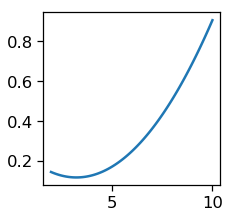

In [32]:
graph_conductance_exp_inc_4('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df)


In [18]:
#Creating matrix for conductance parameter and gene expression to be compared for Spearman correlation
def create_corr_inc_4(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_4 , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inc_4])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    return graph_spec

In [19]:
#Returns rho value (spearman) and pval (p-value)
def spearman_conductance_exp_inc_4(parameter_type, gene_symbol, df):
    graph_spec = create_corr_inc_4(parameter_type, gene_symbol, df)

    spearman_val = graph_spec.corr(method="spearman").iloc[0, 1]
    return spearmanr(graph_spec)

In [21]:
spearman_conductance_exp_inc_4('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df)


SpearmanrResult(correlation=0.5249999999999999, pvalue=0.04448390580010643)

In [60]:
#Set-up for palette for cell types based on Cre-line
cre_color_inh = ['Htr3a-Cre_NO152__L2/3__inh',
             'Htr3a-Cre_NO152__L5__inh',
             'Pvalb-IRES-Cre__L2/3__inh',
             'Pvalb-IRES-Cre__L4__inh',
             'Pvalb-IRES-Cre__L5__inh',
             'Pvalb-IRES-Cre__L6__inh',
             'Sst-IRES-Cre__L1-L2/3__inh',
             'Sst-IRES-Cre__L5__inh',
             'Sst-IRES-Cre__L6__inh']

cre_line_palette_inh = {'Htr3a-Cre_NO152__L2/3__inh':"#DF6BC6",
                    'Htr3a-Cre_NO152__L5__inh':"#DF6BC6", 
                    'Pvalb-IRES-Cre__L2/3__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L4__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L5__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L6__inh':"#CD3449",
                    'Sst-IRES-Cre__L1-L2/3__inh':"#B35F1F",
                    'Sst-IRES-Cre__L5__inh':"#B35F1F",
                    'Sst-IRES-Cre__L6__inh':"#B35F1F"}

In [80]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_inh(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inh , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inh])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    plt.figure(figsize=(8, 8))
    plt.title('Correspondence of {} relative conductance \n and {} gene expression by Cre driver line'.format(parameter_type, gene_symbol))
    
    
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=cre_color_inh, data=graph_spec, s = 100, palette=cre_line_palette_inh)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Driver Lines")

    ax.set(xlabel='{} Transcriptomic Gene Expression'.format(gene_symbol), ylabel='{} Conductance'.format(parameter_type))

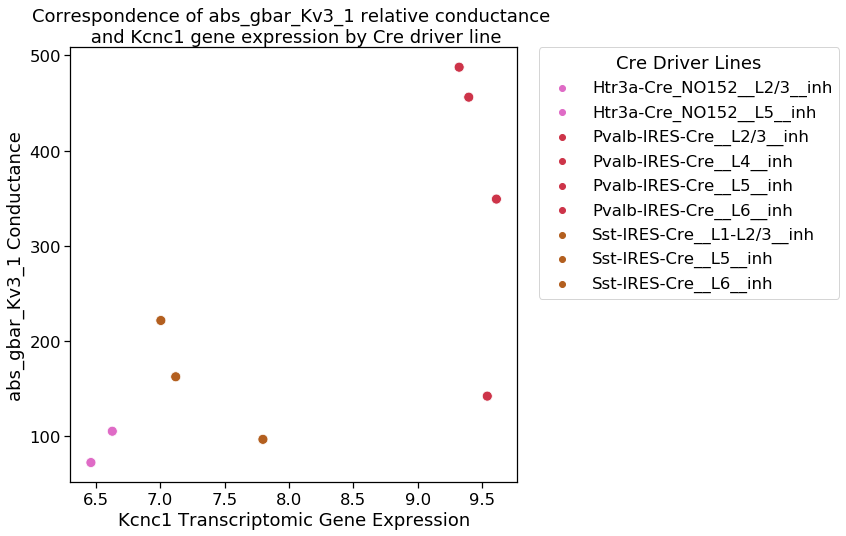

In [81]:
graph_conductance_exp_inh('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

In [82]:
#Creating matrix for conductance parameter and gene expression to be compared for Spearman correlation
def create_corr_inh(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inh , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inh])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    return graph_spec

In [83]:
#Returns rho value (spearman) and pval (p-value)
def spearman_conductance_exp_inh(parameter_type, gene_symbol, df):
    graph_spec = create_corr_inh(parameter_type, gene_symbol, df)

    spearman_val = graph_spec.corr(method="spearman").iloc[0, 1]
    return spearmanr(graph_spec)

In [20]:
spearman_conductance_exp_inh('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

NameError: name 'spearman_conductance_exp_inh' is not defined

In [85]:
#Set-up for palette for cell types based on Cre-line
cre_color_exc = ['Nr5a1-Cre__L4__exc',
             'Ntsr1-Cre_GN220__L6__exc',
             'Rbp4-Cre_KL100__L4__exc',
             'Rbp4-Cre_KL100__L5__exc',
             'Scnn1a-Tg2-Cre__L4__exc',
             'Scnn1a-Tg3-Cre__L2/3-L4__exc']

cre_line_palette_exc = {'Nr5a1-Cre__L4__exc':"#43BCA9",
                    'Ntsr1-Cre_GN220__L6__exc':"#70849A",
                    'Rbp4-Cre_KL100__L4__exc':"#009B81",
                    'Rbp4-Cre_KL100__L5__exc':"#009B81",
                    'Scnn1a-Tg2-Cre__L4__exc':"#59B7B4",
                    'Scnn1a-Tg3-Cre__L2/3-L4__exc':"#65AA8A"}

In [86]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_exc(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_exc , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_exc])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    plt.figure(figsize=(8, 8))
    plt.title('Correspondence of {} relative conductance \n and {} gene expression by Cre driver line'.format(parameter_type, gene_symbol))
    
    
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=cre_color_exc, data=graph_spec, s = 100, palette=cre_line_palette_exc)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Driver Lines")

    ax.set(xlabel='{} Transcriptomic Gene Expression'.format(gene_symbol), ylabel='{} Conductance'.format(parameter_type))

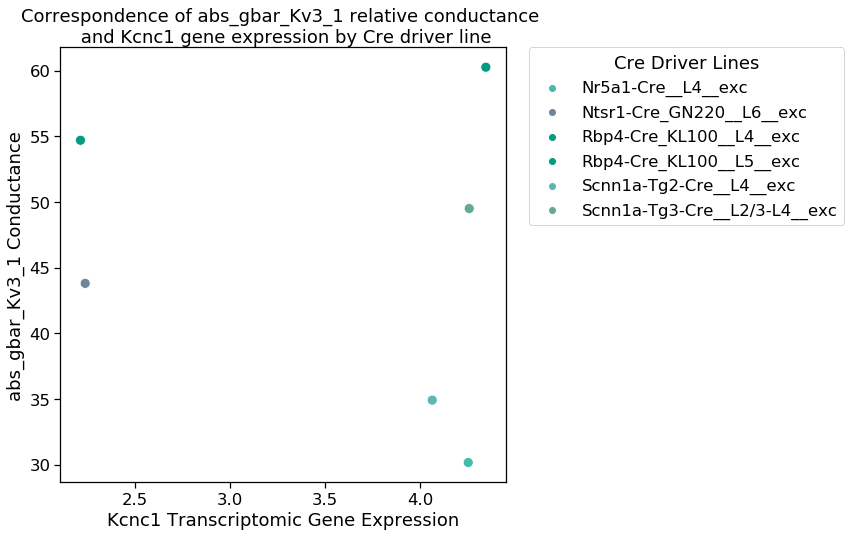

In [87]:
graph_conductance_exp_exc('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

In [88]:
#Creating matrix for conductance parameter and gene expression to be compared for Spearman correlation
def create_corr_exc(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_exc , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_exc])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    return graph_spec

In [89]:
#Returns rho value (spearman) and pval (p-value)
def spearman_conductance_exp_exc(parameter_type, gene_symbol, df):
    graph_spec = create_corr_exc(parameter_type, gene_symbol, df)

    spearman_val = graph_spec.corr(method="spearman").iloc[0, 1]
    return spearmanr(graph_spec)

In [92]:
spearman_conductance_exp_exc('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

SpearmanrResult(correlation=0.2, pvalue=0.704)

In [93]:
#Set-up for palette for cell types based on Cre-line
cre_color_Pval = ['Pvalb-IRES-Cre__L2/3__inh',
             'Pvalb-IRES-Cre__L4__inh',
             'Pvalb-IRES-Cre__L5__inh',
             'Pvalb-IRES-Cre__L6__inh']

cre_line_palette_Pval = {'Pvalb-IRES-Cre__L2/3__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L4__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L5__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L6__inh':"#CD3449"}

In [94]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_Pval(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_Pval , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_Pval])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    plt.figure(figsize=(8, 8))
    plt.title('Correspondence of {} relative conductance \n and {} gene expression by Cre driver line'.format(parameter_type, gene_symbol))
    
    
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=cre_color_Pval, data=graph_spec, s = 100, palette=cre_line_palette_Pval)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Driver Lines")

    ax.set(xlabel='{} Transcriptomic Gene Expression'.format(gene_symbol), ylabel='{} Conductance'.format(parameter_type))

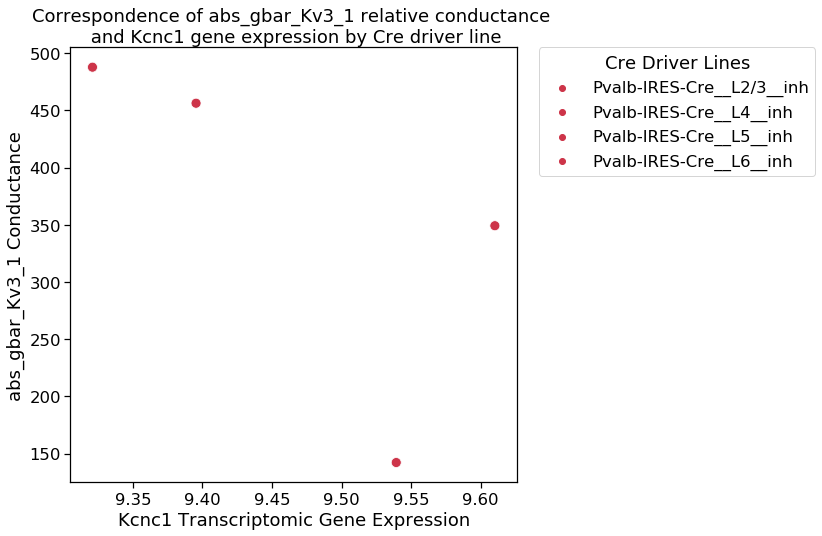

In [95]:
graph_conductance_exp_Pval('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

In [97]:
#Set-up for palette for cell types based on Cre-line
cre_color_Sst = ['Sst-IRES-Cre__L1-L2/3__inh',
             'Sst-IRES-Cre__L5__inh',
             'Sst-IRES-Cre__L6__inh']

cre_line_palette_Sst = {'Sst-IRES-Cre__L1-L2/3__inh':"#B35F1F",
                    'Sst-IRES-Cre__L5__inh':"#B35F1F",
                    'Sst-IRES-Cre__L6__inh':"#B35F1F"}

In [98]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_Sst(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_Sst , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_Sst])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    plt.figure(figsize=(8, 8))
    plt.title('Correspondence of {} relative conductance \n and {} gene expression by Cre driver line'.format(parameter_type, gene_symbol))
    
    
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=cre_color_Sst, data=graph_spec, s = 100, palette=cre_line_palette_Sst)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Driver Lines")

    ax.set(xlabel='{} Transcriptomic Gene Expression'.format(gene_symbol), ylabel='{} Conductance'.format(parameter_type))

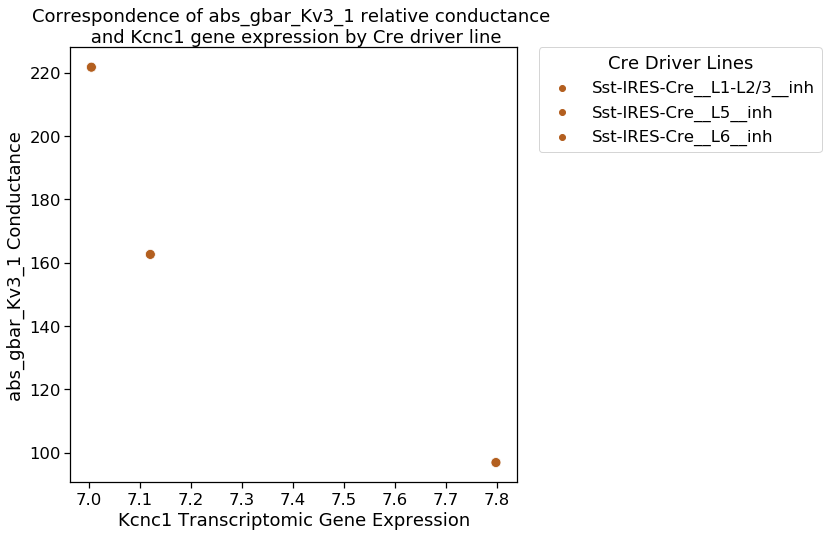

In [99]:
graph_conductance_exp_Sst('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

In [140]:
#Set-up for palette for cell types based on Cre-line
cre_color_exc_4 = ['Htr3a-Cre_NO152__L2/3__inh',
             'Nr5a1-Cre__L4__exc',
             'Ntsr1-Cre_GN220__L6__exc',
             'Pvalb-IRES-Cre__L2/3__inh',
             'Pvalb-IRES-Cre__L4__inh',
             'Pvalb-IRES-Cre__L5__inh',
             'Rbp4-Cre_KL100__L4__exc',
             'Rbp4-Cre_KL100__L5__exc',
             'Scnn1a-Tg2-Cre__L4__exc',
             'Scnn1a-Tg3-Cre__L2/3-L4__exc',
             'Sst-IRES-Cre__L1-L2/3__inh',
             'Sst-IRES-Cre__L5__inh']

cre_line_palette_exc_4 = {'Htr3a-Cre_NO152__L2/3__inh':"#DF6BC6",
                    'Nr5a1-Cre__L4__exc':"#43BCA9",
                    'Ntsr1-Cre_GN220__L6__exc':"#70849A",
                    'Pvalb-IRES-Cre__L2/3__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L4__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L5__inh':"#CD3449",
                    'Rbp4-Cre_KL100__L4__exc':"#009B81",
                    'Rbp4-Cre_KL100__L5__exc':"#009B81",
                    'Scnn1a-Tg2-Cre__L4__exc':"#59B7B4",
                    'Scnn1a-Tg3-Cre__L2/3-L4__exc':"#65AA8A",
                    'Sst-IRES-Cre__L1-L2/3__inh':"#B35F1F",
                    'Sst-IRES-Cre__L5__inh':"#B35F1F"}

In [141]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_exc_4(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_exc_4 , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_exc_4])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    plt.figure(figsize=(8, 8))
    plt.title('Correspondence of {} relative conductance \n and {} gene expression by Cre driver line'.format(parameter_type, gene_symbol))
    
    
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=cre_color_exc_4, data=graph_spec, s = 100, palette=cre_line_palette_exc_4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Driver Lines")

    ax.set(xlabel='{} Transcriptomic Gene Expression'.format(gene_symbol), ylabel='{} Conductance'.format(parameter_type))

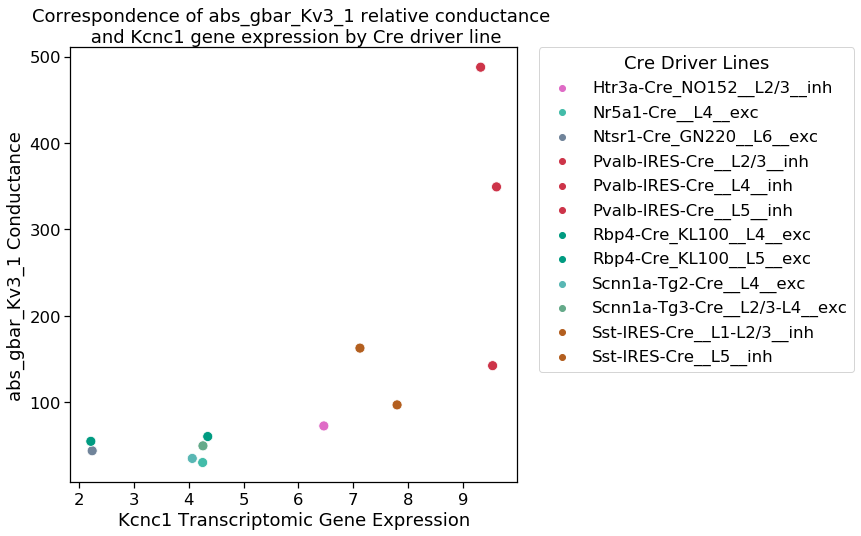

In [142]:
graph_conductance_exp_exc_4('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

In [149]:
#Creating matrix for conductance parameter and gene expression to be compared for Spearman correlation
def create_corr_exc_4(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_exc_4 , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_exc_4])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    return graph_spec

In [150]:
#Returns rho value (spearman) and pval (p-value)
def spearman_conductance_exp_exc_4(parameter_type, gene_symbol, df):
    graph_spec = create_corr_exc_4(parameter_type, gene_symbol, df)

    spearman_val = graph_spec.corr(method="spearman").iloc[0, 1]
    return spearmanr(graph_spec)

In [151]:
spearman_conductance_exp_exc_4('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

SpearmanrResult(correlation=0.8531468531468532, pvalue=0.00041811794041499725)

In [34]:
#Set-up for palette for cell types based on Cre-line
cre_color_8 = ['Htr3a-Cre_NO152__L2/3__inh',
             'Nr5a1-Cre__L4__exc',
             'Pvalb-IRES-Cre__L5__inh',
             'Rbp4-Cre_KL100__L5__exc',
             'Scnn1a-Tg2-Cre__L4__exc',
             'Scnn1a-Tg3-Cre__L2/3-L4__exc',
             'Sst-IRES-Cre__L5__inh']

cre_line_palette_8 = {'Htr3a-Cre_NO152__L2/3__inh':"#DF6BC6",
                    'Nr5a1-Cre__L4__exc':"#43BCA9",
                    'Pvalb-IRES-Cre__L5__inh':"#CD3449",
                    'Rbp4-Cre_KL100__L5__exc':"#009B81",
                    'Scnn1a-Tg2-Cre__L4__exc':"#59B7B4",
                    'Scnn1a-Tg3-Cre__L2/3-L4__exc':"#65AA8A",
                    'Sst-IRES-Cre__L5__inh':"#B35F1F"}

In [35]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_8(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_8 , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_8])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    plt.figure(figsize=(8, 8))
    plt.title('Correspondence of {} relative conductance \n and {} gene expression by Cre driver line'.format(parameter_type, gene_symbol))
    
    
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=cre_color_8, data=graph_spec, s = 100, palette=cre_line_palette_8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cre Driver Lines")

    ax.set(xlabel='{} Transcriptomic Gene Expression'.format(gene_symbol), ylabel='{} Conductance'.format(parameter_type))

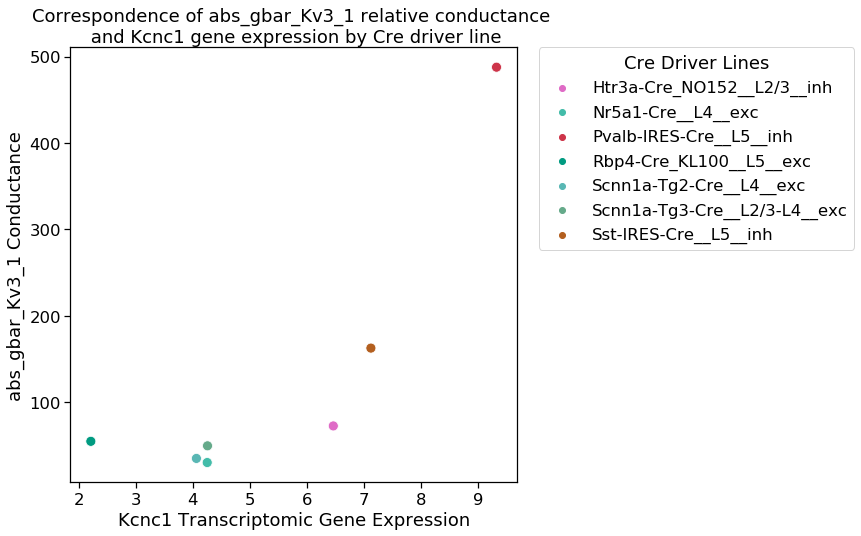

In [38]:
graph_conductance_exp_8('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

In [152]:
#Creating matrix for conductance parameter and gene expression to be compared for Spearman correlation
def create_corr_8(parameter_type, gene_symbol, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_8 , : ]
    filtered_cre = list(cre_conductance_filtered.index)
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_8])
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    return graph_spec

In [153]:
#Returns rho value (spearman) and pval (p-value)
def spearman_conductance_exp_8(parameter_type, gene_symbol, df):
    graph_spec = create_corr_8(parameter_type, gene_symbol, df)

    spearman_val = graph_spec.corr(method="spearman").iloc[0, 1]
    return spearmanr(graph_spec)

In [154]:
spearman_conductance_exp_8('abs_gbar_Kv3_1', 'Kcnc1', abs_parameter_df)

SpearmanrResult(correlation=0.7500000000000002, pvalue=0.05218140045705776)

In [157]:
compare_types = all_features_cell_type[all_features_cell_type['gbar_Kv3_1'].notna()]
compare_types = compare_types[compare_types['cell_type'] == 'Htr3a-Cre_NO152__L2/3__inh']
compare_types['type'] = 'null'
for index, row in compare_types.iterrows():
    if math.isnan(row['gbar_Im']):
        compare_types.at[index, 'type'] = 'thin'
    else:
        compare_types.at[index, 'type'] = 'wide'
compare_types

,cell_type,gbar_Im,gbar_Ih,gbar_NaTs,gbar_Nap,gbar_K_P,gbar_K_T,gbar_SK,gbar_Kv3_1,gbar_Ca_HVA,...,axon_g_pas,dend_g_pas,apic_g_pas,gbar_NaV,gbar_Kd,gbar_Kv2like,gbar_Im_v2,cre_line,dendrite_type,type
466,Htr3a-Cre_NO152__L2/3__inh,0.000586,4.427352e-03,0.470650,0.002263,0.009459,1.215759e-01,1.590725e-01,0.690119,0.000898,...,0.000371,1.018433e-07,NaN,NaN,NaN,NaN,NaN,Htr3a-Cre_NO152,aspiny,wide
620,Htr3a-Cre_NO152__L2/3__inh,0.001224,6.968697e-04,0.512922,0.002113,0.145267,7.780540e-02,4.386119e-01,0.308194,0.000899,...,0.000664,9.867081e-06,NaN,NaN,NaN,NaN,NaN,Htr3a-Cre_NO152,aspiny,wide
1325,Htr3a-Cre_NO152__L2/3__inh,NaN,2.906863e-05,NaN,NaN,NaN,1.707520e-06,3.271238e-04,0.135291,0.000232,...,0.000237,6.147151e-04,NaN,0.060446,8.011760e-05,0.049683,0.000011,Htr3a-Cre_NO152,aspiny,thin
1352,Htr3a-Cre_NO152__L2/3__inh,0.000163,2.226790e-06,0.443293,0.001304,0.085682,1.971026e-02,5.576038e-04,0.378163,0.000279,...,0.000985,5.870819e-04,NaN,NaN,NaN,NaN,NaN,Htr3a-Cre_NO152,aspiny,wide
1467,Htr3a-Cre_NO152__L2/3__inh,NaN,1.109010e-03,NaN,NaN,NaN,1.480819e-02,5.342999e-04,0.161057,0.000018,...,0.001000,1.444995e-07,NaN,0.082794,2.823956e-07,0.097892,0.000277,Htr3a-Cre_NO152,aspiny,thin
1721,Htr3a-Cre_NO152__L2/3__inh,0.002348,8.870448e-05,0.381411,0.000577,0.000287,5.943800e-04,3.824370e-04,0.215882,0.000119,...,0.000715,2.533879e-07,NaN,NaN,NaN,NaN,NaN,Htr3a-Cre_NO152,aspiny,wide
1879,Htr3a-Cre_NO152__L2/3__inh,NaN,4.104983e-08,NaN,NaN,NaN,2.291519e-05,7.662927e-13,0.063256,0.000028,...,0.000993,1.164118e-06,NaN,0.028894,2.806229e-05,0.001966,0.002690,Htr3a-Cre_NO152,aspiny,thin
2018,Htr3a-Cre_NO152__L2/3__inh,NaN,1.618803e-06,NaN,NaN,NaN,6.721320e-07,6.718358e-03,0.065294,0.000712,...,0.000233,2.662962e-04,NaN,0.044198,2.593347e-07,0.000770,0.003052,Htr3a-Cre_NO152,aspiny,thin
2076,Htr3a-Cre_NO152__L2/3__inh,NaN,5.110728e-04,NaN,NaN,NaN,1.641168e-02,9.116731e-07,0.101361,0.000074,...,0.000002,1.283217e-05,NaN,0.047250,2.524557e-07,0.000082,0.006800,Htr3a-Cre_NO152,aspiny,thin


In [158]:
def graph_type_diff(parameter_type):
    ax = sns.catplot(x='type', y=parameter_type, data=compare_types)

    ax.set(xlabel='Type', ylabel='{} Conductance'.format(parameter_type))

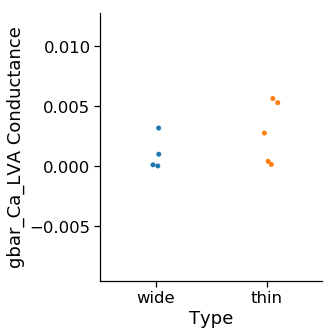

In [161]:
graph_type_diff('gbar_Ca_LVA')